In [1]:
import warnings
warnings.filterwarnings('always')
warnings.filterwarnings('ignore')

In [2]:
from tensorflow.python.client import device_lib
device_lib.list_local_devices()

[name: "/device:CPU:0"
 device_type: "CPU"
 memory_limit: 268435456
 locality {
 }
 incarnation: 15632010622098936826, name: "/device:GPU:0"
 device_type: "GPU"
 memory_limit: 9234857329
 locality {
   bus_id: 1
   links {
   }
 }
 incarnation: 3700156079174324014
 physical_device_desc: "device: 0, name: GeForce GTX 1080 Ti, pci bus id: 0000:01:00.0, compute capability: 6.1"]

In [3]:
from hyperopt import fmin, tpe, hp, STATUS_OK, Trials, partial, rand, space_eval
from sklearn.metrics import log_loss
import sys
import time
import math
import os
import pandas as pd
from keras.callbacks import EarlyStopping
import numpy as np
from glob import glob
import cv2
import skimage
from skimage.transform import resize
from keras.utils.np_utils import to_categorical
import keras
from keras import layers
from keras import models
from keras import optimizers
from keras.models import load_model
# import keras.callbacks as kcall
from keras.optimizers import Adam, RMSprop,SGD
from keras.models import Model
from keras.models import Sequential
from keras.layers import Flatten, Dense, Activation, Dropout, Conv2D, MaxPooling2D, BatchNormalization, GlobalAveragePooling2D
from keras.applications.xception import Xception, preprocess_input
from keras.preprocessing.image import ImageDataGenerator
# from keras.callbacks import EarlyStopping, TensorBoard, ModelCheckpoint
from keras.regularizers import l2, l1

from sklearn.metrics import accuracy_score,roc_curve, confusion_matrix, roc_auc_score, auc, f1_score

import matplotlib.pyplot as plt
from keras.layers import Input, concatenate
from keras import optimizers, metrics, models
from keras.layers import Input, Flatten, Dense

%matplotlib inline

Using TensorFlow backend.


In [4]:
import keras
import tensorflow as tf

print("Keras Version", keras.__version__)
print("tensorflow Version", tf.__version__)
# print("dim_ordering:", K.image_dim_ordering())

Keras Version 2.2.4
tensorflow Version 1.10.0


In [5]:
# print(os.listdir(""))

In [6]:
batch_size = 512
img_height, img_width = 128, 128
input_shape = (img_height, img_width, 3)
epochs = 1000

In [7]:
train_dir = 'data/train/'
test_dir = 'data/test'

In [8]:
def preprocess_input(x):
    # 'RGB'->'BGR'
    x = x[:, :, ::-1]
    # Zero-center by imagenet mean pixel
    x[:, :, 0] -= 103.939
    x[:, :, 1] -= 116.779
    x[:, :, 2] -= 123.68
    return x

In [9]:
random_seed = np.random.seed(1142)

train_datagen = ImageDataGenerator(
    rescale=1. / 255,
#     featurewise_center=True,
#     featurewise_std_normalization=True,
    preprocessing_function = preprocess_input,
    validation_split= 0.2,
    zoom_range=0.2,
    shear_range=0.2)

train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=(img_height, img_width),
    batch_size=batch_size,
    seed = random_seed,
    shuffle = False,
    subset = 'training',
    class_mode='categorical')

validation_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=(img_height, img_width),
    batch_size=batch_size,
    seed = random_seed,
    shuffle = False,
    subset = 'validation',
    class_mode='categorical')

test_datagen = ImageDataGenerator(rescale=1. / 255, preprocessing_function = preprocess_input)
test_generator = test_datagen.flow_from_directory(
    test_dir,
    target_size=(img_height, img_width),
    batch_size=batch_size,
    seed = random_seed,
    shuffle = False,
    class_mode='categorical')

Found 319152 images belonging to 6 classes.
Found 79784 images belonging to 6 classes.
Found 13578 images belonging to 6 classes.


In [10]:
nb_train_samples = len(train_generator.filenames)
nb_validation_samples = len(validation_generator.filenames)
nb_test_samples = len(test_generator.filenames)

predict_size_train = int(math.ceil(nb_train_samples / batch_size))
predict_size_validation = int(math.ceil(nb_validation_samples / batch_size))
predict_size_test = int(math.ceil(nb_test_samples / batch_size))

num_classes = len(train_generator.class_indices)

print("nb_train_samples:", nb_train_samples)
print("nb_validation_samples:", nb_validation_samples)
print("nb_test_samples:", nb_test_samples)

print("\npredict_size_train:", predict_size_train)
print("predict_size_validation:", predict_size_validation)
print("predict_size_test:", predict_size_test)

print("\n num_classes:", num_classes)

nb_train_samples: 319152
nb_validation_samples: 79784
nb_test_samples: 13578

predict_size_train: 624
predict_size_validation: 156
predict_size_test: 27

 num_classes: 6


In [11]:
# os.mkdir("extracted_features")
extracted_features_dir = "extracted_features/"
model_name = "Xception"

In [12]:
# vgg19_weights ="../input/full-keras-pretrained-no-top/vgg19_weights_tf_dim_ordering_tf_kernels_notop.h5"
# inception_weights ="../input/full-keras-pretrained-no-top//inception_v3_weights_tf_dim_ordering_tf_kernels_notop.h5"
# vgg16_weights ="../input/full-keras-pretrained-no-top/vgg16_weights_tf_dim_ordering_tf_kernels_notop.h5"
# denseNet201_weights ="../input/full-keras-pretrained-no-top/densenet201_weights_tf_dim_ordering_tf_kernels_notop.h5"
# denseNet121_weights ="../input/full-keras-pretrained-no-top/densenet121_weights_tf_dim_ordering_tf_kernels_notop.h5"
# resenet50_weights ="../input/full-keras-pretrained-no-top/resnet50_weights_tf_dim_ordering_tf_kernels_notop.h5"
# inception_resnet_v2_weights ="../input/full-keras-pretrained-no-top/inception_resnet_v2_weights_tf_dim_ordering_tf_kernels_notop.h5"
# nasnet_weights ="../input/full-keras-pretrained-no-top/nasnet_large_no_top.h5"
# nasnet_mobile_weights ="../input/full-keras-pretrained-no-top/nasnet_mobile_no_top.h5"
# mobilenet_weights ="../input/full-keras-pretrained-no-top/mobilenet_1_0_224_tf_no_top.h5"
# xception_weights = "../input/full-keras-pretrained-no-top/xception_weights_tf_dim_ordering_tf_kernels_notop.h5"

In [ ]:
# from keras.applications.vgg19 import VGG19
from keras.applications.inception_v3 import InceptionV3
# from keras.applications.vgg16 import VGG16
from keras.applications.xception import Xception, preprocess_input
from keras.applications import DenseNet201
# from keras.applications import DenseNet121
# from keras.applications import ResNet50
# from keras.applications.inception_resnet_v2 import InceptionResNetV2
# from keras.applications import NASNetLarge, NASNetMobile
# from keras.applications import MobileNet

In [ ]:
# input_tensor = Input(shape = input_shape)  

# base_model1=InceptionV3(input_shape= input_shape,weights=inception_weights, include_top=False, input_tensor=input_tensor)
# base_model2=Xception(input_shape= input_shape,weights=xception_weights, include_top=False, input_tensor=input_tensor)

# x1 = base_model1.output
# x1 = GlobalAveragePooling2D()(x1)

# x2 = base_model2.output
# x2 = GlobalAveragePooling2D()(x2)

# merge = concatenate([x1, x2])
# predictions = Dense(num_classes, activation='softmax')(merge)

# model = Model(inputs=input_tensor,outputs=predictions)

In [ ]:
# for i, layer in enumerate(model.layers):
#     print(i, layer.name)

In [ ]:
# c1 = model.layers[11].output 
# c1 = GlobalAveragePooling2D()(c1)       

# c2 = model.layers[21].output
# c2 = GlobalAveragePooling2D()(c2)       

# c3 = model.layers[28].output
# c3 = GlobalAveragePooling2D()(c3)       

# c4 = model.layers[51].output
# c4 = GlobalAveragePooling2D()(c4) 

# c5 = model.layers[84].output
# c5 = GlobalAveragePooling2D()(c5) 

# c6 = model.layers[103].output
# c6 = GlobalAveragePooling2D()(c6) 

# c7 = model.layers[117].output
# c7 = GlobalAveragePooling2D()(c7) 

# c8 = model.layers[129].output
# c8 = GlobalAveragePooling2D()(c8) 

# c9 = model.layers[143].output
# c9 = GlobalAveragePooling2D()(c9) 

# c10 = model.layers[162].output
# c10 = GlobalAveragePooling2D()(c10) 

# c11 = model.layers[210].output
# c11 = GlobalAveragePooling2D()(c11) 

# c12 = model.layers[258].output
# c12 = GlobalAveragePooling2D()(c12) 

# c13 = model.layers[306].output
# c13 = GlobalAveragePooling2D()(c13) 

# c14 = model.layers[356].output
# c14 = GlobalAveragePooling2D()(c14) 

# c15 = model.layers[377].output
# c15 = GlobalAveragePooling2D()(c15) 

# c16 = model.layers[415].output
# c16 = GlobalAveragePooling2D()(c16) 

# c17 = model.layers[421].output
# c17 = GlobalAveragePooling2D()(c17) 

# con = concatenate([c1, c2, c3, c4, c5, c6, c7, c8, c9, c10, c11, c12, c13, c14, c15, c16])

# bottleneck_final_model = Model(inputs=model.input, outputs=con)

In [13]:
model = Xception(weights="imagenet", include_top=False, pooling = 'avg', input_tensor=Input(shape=input_shape))

In [14]:
bottleneck_final_model = model

In [15]:
bottleneck_features_train = bottleneck_final_model.predict_generator(train_generator, predict_size_train, max_q_size=1, pickle_safe=False)
np.save(extracted_features_dir+'bottleneck_features_train_'+model_name+'.npy', bottleneck_features_train)

In [16]:
bottleneck_features_validation = bottleneck_final_model.predict_generator(validation_generator, predict_size_validation)
np.save(extracted_features_dir+'bottleneck_features_validation_'+model_name+'.npy', bottleneck_features_validation)

In [17]:
bottleneck_features_test = bottleneck_final_model.predict_generator(test_generator, predict_size_test)
np.save(extracted_features_dir+'bottleneck_features_test_'+model_name+'.npy', bottleneck_features_test)

In [18]:
# import tensorflow as tf
# from keras.backend.tensorflow_backend import get_session
# from keras.backend.tensorflow_backend import clear_session
# from keras.backend.tensorflow_backend import set_session

# def reset_keras_tf_session():
#     """
#     this function clears the gpu memory and set the 
#     tf session to not use the whole gpu
#     """
#     sess = get_session()
#     clear_session()
#     sess.close()
#     sess = get_session()

# #     config = tf.ConfigProto()
# #     config.gpu_options.allow_growth = True
# #     set_session(tf.Session(config=config))

# reset_keras_tf_session()

In [19]:
train_data = np.load(extracted_features_dir+'bottleneck_features_train_'+model_name+'.npy')
validation_data = np.load(extracted_features_dir+'bottleneck_features_validation_'+model_name+'.npy')
test_data = np.load(extracted_features_dir+'bottleneck_features_test_'+model_name+'.npy')

train_labels = train_generator.classes
train_labels = to_categorical(train_labels, num_classes=num_classes)

validation_labels = validation_generator.classes
validation_labels = to_categorical(validation_labels, num_classes=num_classes)

test_labels = test_generator.classes
test_labels = to_categorical(test_labels, num_classes=num_classes)

In [20]:
# dropout_rate = 0.5

model = Sequential()
# model.add(Flatten(input_shape=train_data.shape[1:]))
model.add(Dense(2048, activation="softplus", kernel_regularizer=l2(1e-05), bias_regularizer=l2(0.0001), activity_regularizer=l1(1e-07)))
model.add(Dropout(0.25))

model.add(Dense(256, activation="softplus", kernel_regularizer=l2(1e-05), bias_regularizer=l2(0.0001), activity_regularizer=l1(1e-07)))
model.add(Dropout(0.5))
    
model.add(Dense(num_classes, activation="softmax"))

adam_opt=Adam(lr = 0.0001, beta_1=0.8, beta_2=0.99)

model.compile(optimizer=adam_opt, loss='categorical_crossentropy', metrics=['accuracy'])

history = model.fit(train_data, train_labels,
                    epochs=1000,
                    batch_size=batch_size,
                    validation_data=(validation_data, validation_labels),
                    verbose= 2)

with open(extracted_features_dir+'history_'+model_name+'.txt','w') as f:
    f.write(str(history.history))

# model.save_weights(top_model_weights_path)
# model.save(top_model_path)

Train on 319152 samples, validate on 79784 samples
Epoch 1/1000
 - 9s - loss: 1.0956 - acc: 0.6130 - val_loss: 0.8533 - val_acc: 0.7305
Epoch 2/1000
 - 7s - loss: 0.7889 - acc: 0.7373 - val_loss: 0.7205 - val_acc: 0.7752
Epoch 3/1000
 - 7s - loss: 0.7026 - acc: 0.7740 - val_loss: 0.6583 - val_acc: 0.7959
Epoch 4/1000
 - 7s - loss: 0.6597 - acc: 0.7904 - val_loss: 0.6351 - val_acc: 0.8072
Epoch 5/1000
 - 7s - loss: 0.6329 - acc: 0.8002 - val_loss: 0.6043 - val_acc: 0.8137
Epoch 6/1000
 - 7s - loss: 0.6147 - acc: 0.8069 - val_loss: 0.5914 - val_acc: 0.8186
Epoch 7/1000
 - 7s - loss: 0.6004 - acc: 0.8124 - val_loss: 0.5762 - val_acc: 0.8243
Epoch 8/1000
 - 7s - loss: 0.5904 - acc: 0.8165 - val_loss: 0.5655 - val_acc: 0.8293
Epoch 9/1000
 - 7s - loss: 0.5812 - acc: 0.8197 - val_loss: 0.5621 - val_acc: 0.8300
Epoch 10/1000
 - 7s - loss: 0.5746 - acc: 0.8227 - val_loss: 0.5559 - val_acc: 0.8331
Epoch 11/1000
 - 7s - loss: 0.5685 - acc: 0.8244 - val_loss: 0.5474 - val_acc: 0.8347
Epoch 12/100

Epoch 96/1000
 - 7s - loss: 0.4983 - acc: 0.8523 - val_loss: 0.4772 - val_acc: 0.8625
Epoch 97/1000
 - 7s - loss: 0.4978 - acc: 0.8524 - val_loss: 0.4743 - val_acc: 0.8643
Epoch 98/1000
 - 7s - loss: 0.4977 - acc: 0.8526 - val_loss: 0.4767 - val_acc: 0.8630
Epoch 99/1000
 - 7s - loss: 0.4974 - acc: 0.8522 - val_loss: 0.4787 - val_acc: 0.8625
Epoch 100/1000
 - 7s - loss: 0.4970 - acc: 0.8528 - val_loss: 0.4761 - val_acc: 0.8654
Epoch 101/1000
 - 7s - loss: 0.4969 - acc: 0.8530 - val_loss: 0.4783 - val_acc: 0.8624
Epoch 102/1000
 - 7s - loss: 0.4966 - acc: 0.8530 - val_loss: 0.4737 - val_acc: 0.8665
Epoch 103/1000
 - 7s - loss: 0.4976 - acc: 0.8520 - val_loss: 0.4758 - val_acc: 0.8645
Epoch 104/1000
 - 7s - loss: 0.4971 - acc: 0.8523 - val_loss: 0.4764 - val_acc: 0.8643
Epoch 105/1000
 - 7s - loss: 0.4964 - acc: 0.8536 - val_loss: 0.4755 - val_acc: 0.8648
Epoch 106/1000
 - 7s - loss: 0.4956 - acc: 0.8538 - val_loss: 0.4752 - val_acc: 0.8648
Epoch 107/1000
 - 7s - loss: 0.4956 - acc: 0.85

Epoch 191/1000
 - 7s - loss: 0.4892 - acc: 0.8562 - val_loss: 0.4665 - val_acc: 0.8674
Epoch 192/1000
 - 7s - loss: 0.4881 - acc: 0.8568 - val_loss: 0.4666 - val_acc: 0.8678
Epoch 193/1000
 - 7s - loss: 0.4883 - acc: 0.8563 - val_loss: 0.4664 - val_acc: 0.8691
Epoch 194/1000
 - 7s - loss: 0.4880 - acc: 0.8566 - val_loss: 0.4697 - val_acc: 0.8665
Epoch 195/1000
 - 7s - loss: 0.4877 - acc: 0.8572 - val_loss: 0.4672 - val_acc: 0.8675
Epoch 196/1000
 - 7s - loss: 0.4875 - acc: 0.8574 - val_loss: 0.4727 - val_acc: 0.8626
Epoch 197/1000
 - 7s - loss: 0.4867 - acc: 0.8573 - val_loss: 0.4650 - val_acc: 0.8676
Epoch 198/1000
 - 7s - loss: 0.4883 - acc: 0.8565 - val_loss: 0.4653 - val_acc: 0.8690
Epoch 199/1000
 - 7s - loss: 0.4865 - acc: 0.8571 - val_loss: 0.4690 - val_acc: 0.8676
Epoch 200/1000
 - 7s - loss: 0.4877 - acc: 0.8573 - val_loss: 0.4666 - val_acc: 0.8693
Epoch 201/1000
 - 7s - loss: 0.4864 - acc: 0.8572 - val_loss: 0.4638 - val_acc: 0.8700
Epoch 202/1000
 - 7s - loss: 0.4863 - acc: 

 - 7s - loss: 0.4830 - acc: 0.8591 - val_loss: 0.4556 - val_acc: 0.8722
Epoch 286/1000
 - 7s - loss: 0.4823 - acc: 0.8592 - val_loss: 0.4595 - val_acc: 0.8677
Epoch 287/1000
 - 7s - loss: 0.4844 - acc: 0.8593 - val_loss: 0.4618 - val_acc: 0.8708
Epoch 288/1000
 - 7s - loss: 0.4827 - acc: 0.8592 - val_loss: 0.4606 - val_acc: 0.8705
Epoch 289/1000
 - 7s - loss: 0.4836 - acc: 0.8593 - val_loss: 0.4595 - val_acc: 0.8715
Epoch 290/1000
 - 7s - loss: 0.4836 - acc: 0.8583 - val_loss: 0.4602 - val_acc: 0.8715
Epoch 291/1000
 - 7s - loss: 0.4833 - acc: 0.8590 - val_loss: 0.4621 - val_acc: 0.8712
Epoch 292/1000
 - 7s - loss: 0.4825 - acc: 0.8596 - val_loss: 0.4622 - val_acc: 0.8711
Epoch 293/1000
 - 7s - loss: 0.4819 - acc: 0.8598 - val_loss: 0.4619 - val_acc: 0.8693
Epoch 294/1000
 - 7s - loss: 0.4830 - acc: 0.8593 - val_loss: 0.4605 - val_acc: 0.8712
Epoch 295/1000
 - 7s - loss: 0.4831 - acc: 0.8591 - val_loss: 0.4602 - val_acc: 0.8723
Epoch 296/1000
 - 7s - loss: 0.4826 - acc: 0.8601 - val_lo

Epoch 380/1000
 - 7s - loss: 0.4813 - acc: 0.8604 - val_loss: 0.4592 - val_acc: 0.8718
Epoch 381/1000
 - 7s - loss: 0.4806 - acc: 0.8610 - val_loss: 0.4602 - val_acc: 0.8731
Epoch 382/1000
 - 7s - loss: 0.4814 - acc: 0.8604 - val_loss: 0.4587 - val_acc: 0.8710
Epoch 383/1000
 - 7s - loss: 0.4819 - acc: 0.8603 - val_loss: 0.4629 - val_acc: 0.8711
Epoch 384/1000
 - 7s - loss: 0.4810 - acc: 0.8602 - val_loss: 0.4585 - val_acc: 0.8698
Epoch 385/1000
 - 7s - loss: 0.4799 - acc: 0.8610 - val_loss: 0.4603 - val_acc: 0.8735
Epoch 386/1000
 - 7s - loss: 0.4806 - acc: 0.8604 - val_loss: 0.4609 - val_acc: 0.8705
Epoch 387/1000
 - 7s - loss: 0.4810 - acc: 0.8596 - val_loss: 0.4607 - val_acc: 0.8736
Epoch 388/1000
 - 7s - loss: 0.4812 - acc: 0.8604 - val_loss: 0.4611 - val_acc: 0.8717
Epoch 389/1000
 - 7s - loss: 0.4802 - acc: 0.8606 - val_loss: 0.4598 - val_acc: 0.8708
Epoch 390/1000
 - 7s - loss: 0.4806 - acc: 0.8604 - val_loss: 0.4574 - val_acc: 0.8710
Epoch 391/1000
 - 7s - loss: 0.4802 - acc: 

 - 7s - loss: 0.4788 - acc: 0.8614 - val_loss: 0.4546 - val_acc: 0.8746
Epoch 475/1000
 - 7s - loss: 0.4790 - acc: 0.8613 - val_loss: 0.4567 - val_acc: 0.8711
Epoch 476/1000
 - 7s - loss: 0.4787 - acc: 0.8618 - val_loss: 0.4560 - val_acc: 0.8732
Epoch 477/1000
 - 7s - loss: 0.4792 - acc: 0.8617 - val_loss: 0.4596 - val_acc: 0.8697
Epoch 478/1000
 - 7s - loss: 0.4787 - acc: 0.8614 - val_loss: 0.4595 - val_acc: 0.8704
Epoch 479/1000
 - 7s - loss: 0.4784 - acc: 0.8616 - val_loss: 0.4597 - val_acc: 0.8700
Epoch 480/1000
 - 7s - loss: 0.4798 - acc: 0.8616 - val_loss: 0.4580 - val_acc: 0.8740
Epoch 481/1000
 - 7s - loss: 0.4788 - acc: 0.8610 - val_loss: 0.4562 - val_acc: 0.8726
Epoch 482/1000
 - 7s - loss: 0.4794 - acc: 0.8617 - val_loss: 0.4550 - val_acc: 0.8723
Epoch 483/1000
 - 7s - loss: 0.4791 - acc: 0.8610 - val_loss: 0.4538 - val_acc: 0.8733
Epoch 484/1000
 - 7s - loss: 0.4789 - acc: 0.8614 - val_loss: 0.4564 - val_acc: 0.8744
Epoch 485/1000
 - 7s - loss: 0.4793 - acc: 0.8621 - val_lo

Epoch 569/1000
 - 7s - loss: 0.4781 - acc: 0.8627 - val_loss: 0.4550 - val_acc: 0.8724
Epoch 570/1000
 - 7s - loss: 0.4784 - acc: 0.8620 - val_loss: 0.4556 - val_acc: 0.8737
Epoch 571/1000
 - 7s - loss: 0.4785 - acc: 0.8618 - val_loss: 0.4545 - val_acc: 0.8747
Epoch 572/1000
 - 7s - loss: 0.4776 - acc: 0.8621 - val_loss: 0.4561 - val_acc: 0.8743
Epoch 573/1000
 - 7s - loss: 0.4778 - acc: 0.8623 - val_loss: 0.4551 - val_acc: 0.8717
Epoch 574/1000
 - 7s - loss: 0.4781 - acc: 0.8620 - val_loss: 0.4527 - val_acc: 0.8742
Epoch 575/1000
 - 7s - loss: 0.4777 - acc: 0.8626 - val_loss: 0.4603 - val_acc: 0.8685
Epoch 576/1000
 - 7s - loss: 0.4770 - acc: 0.8624 - val_loss: 0.4558 - val_acc: 0.8721
Epoch 577/1000
 - 7s - loss: 0.4769 - acc: 0.8622 - val_loss: 0.4569 - val_acc: 0.8718
Epoch 578/1000
 - 7s - loss: 0.4786 - acc: 0.8622 - val_loss: 0.4546 - val_acc: 0.8739
Epoch 579/1000
 - 7s - loss: 0.4789 - acc: 0.8622 - val_loss: 0.4579 - val_acc: 0.8729
Epoch 580/1000
 - 7s - loss: 0.4778 - acc: 

 - 7s - loss: 0.4776 - acc: 0.8630 - val_loss: 0.4512 - val_acc: 0.8749
Epoch 664/1000
 - 7s - loss: 0.4760 - acc: 0.8625 - val_loss: 0.4539 - val_acc: 0.8760
Epoch 665/1000
 - 7s - loss: 0.4764 - acc: 0.8630 - val_loss: 0.4570 - val_acc: 0.8710
Epoch 666/1000
 - 7s - loss: 0.4777 - acc: 0.8622 - val_loss: 0.4572 - val_acc: 0.8701
Epoch 667/1000
 - 7s - loss: 0.4773 - acc: 0.8632 - val_loss: 0.4522 - val_acc: 0.8752
Epoch 668/1000
 - 7s - loss: 0.4758 - acc: 0.8633 - val_loss: 0.4536 - val_acc: 0.8735
Epoch 669/1000
 - 7s - loss: 0.4769 - acc: 0.8625 - val_loss: 0.4560 - val_acc: 0.8724
Epoch 670/1000
 - 7s - loss: 0.4761 - acc: 0.8632 - val_loss: 0.4564 - val_acc: 0.8722
Epoch 671/1000
 - 7s - loss: 0.4771 - acc: 0.8624 - val_loss: 0.4571 - val_acc: 0.8721
Epoch 672/1000
 - 7s - loss: 0.4769 - acc: 0.8625 - val_loss: 0.4562 - val_acc: 0.8738
Epoch 673/1000
 - 7s - loss: 0.4780 - acc: 0.8621 - val_loss: 0.4549 - val_acc: 0.8732
Epoch 674/1000
 - 7s - loss: 0.4772 - acc: 0.8631 - val_lo

Epoch 758/1000
 - 7s - loss: 0.4760 - acc: 0.8635 - val_loss: 0.4526 - val_acc: 0.8765
Epoch 759/1000
 - 7s - loss: 0.4756 - acc: 0.8634 - val_loss: 0.4528 - val_acc: 0.8740
Epoch 760/1000
 - 7s - loss: 0.4754 - acc: 0.8632 - val_loss: 0.4562 - val_acc: 0.8728
Epoch 761/1000
 - 7s - loss: 0.4763 - acc: 0.8633 - val_loss: 0.4545 - val_acc: 0.8740
Epoch 762/1000
 - 7s - loss: 0.4768 - acc: 0.8627 - val_loss: 0.4535 - val_acc: 0.8761
Epoch 763/1000
 - 7s - loss: 0.4768 - acc: 0.8630 - val_loss: 0.4529 - val_acc: 0.8718
Epoch 764/1000
 - 7s - loss: 0.4748 - acc: 0.8628 - val_loss: 0.4526 - val_acc: 0.8754
Epoch 765/1000
 - 7s - loss: 0.4762 - acc: 0.8630 - val_loss: 0.4520 - val_acc: 0.8754
Epoch 766/1000
 - 7s - loss: 0.4758 - acc: 0.8634 - val_loss: 0.4513 - val_acc: 0.8754
Epoch 767/1000
 - 7s - loss: 0.4756 - acc: 0.8627 - val_loss: 0.4561 - val_acc: 0.8711
Epoch 768/1000
 - 7s - loss: 0.4754 - acc: 0.8634 - val_loss: 0.4520 - val_acc: 0.8768
Epoch 769/1000
 - 7s - loss: 0.4752 - acc: 

 - 7s - loss: 0.4755 - acc: 0.8636 - val_loss: 0.4497 - val_acc: 0.8741
Epoch 853/1000
 - 7s - loss: 0.4744 - acc: 0.8634 - val_loss: 0.4541 - val_acc: 0.8733
Epoch 854/1000
 - 7s - loss: 0.4745 - acc: 0.8637 - val_loss: 0.4532 - val_acc: 0.8743
Epoch 855/1000
 - 7s - loss: 0.4755 - acc: 0.8629 - val_loss: 0.4574 - val_acc: 0.8743
Epoch 856/1000
 - 7s - loss: 0.4757 - acc: 0.8635 - val_loss: 0.4563 - val_acc: 0.8744
Epoch 857/1000
 - 7s - loss: 0.4762 - acc: 0.8633 - val_loss: 0.4496 - val_acc: 0.8731
Epoch 858/1000
 - 7s - loss: 0.4754 - acc: 0.8638 - val_loss: 0.4530 - val_acc: 0.8778
Epoch 859/1000
 - 7s - loss: 0.4742 - acc: 0.8639 - val_loss: 0.4533 - val_acc: 0.8717
Epoch 860/1000
 - 7s - loss: 0.4747 - acc: 0.8635 - val_loss: 0.4512 - val_acc: 0.8765
Epoch 861/1000
 - 7s - loss: 0.4763 - acc: 0.8631 - val_loss: 0.4531 - val_acc: 0.8758
Epoch 862/1000
 - 7s - loss: 0.4755 - acc: 0.8641 - val_loss: 0.4515 - val_acc: 0.8734
Epoch 863/1000
 - 7s - loss: 0.4750 - acc: 0.8634 - val_lo

Epoch 947/1000
 - 7s - loss: 0.4739 - acc: 0.8641 - val_loss: 0.4535 - val_acc: 0.8769
Epoch 948/1000
 - 7s - loss: 0.4743 - acc: 0.8641 - val_loss: 0.4524 - val_acc: 0.8744
Epoch 949/1000
 - 7s - loss: 0.4749 - acc: 0.8633 - val_loss: 0.4548 - val_acc: 0.8740
Epoch 950/1000
 - 7s - loss: 0.4745 - acc: 0.8643 - val_loss: 0.4505 - val_acc: 0.8747
Epoch 951/1000
 - 7s - loss: 0.4744 - acc: 0.8641 - val_loss: 0.4522 - val_acc: 0.8748
Epoch 952/1000
 - 7s - loss: 0.4746 - acc: 0.8637 - val_loss: 0.4519 - val_acc: 0.8747
Epoch 953/1000
 - 7s - loss: 0.4735 - acc: 0.8645 - val_loss: 0.4547 - val_acc: 0.8752
Epoch 954/1000
 - 7s - loss: 0.4743 - acc: 0.8641 - val_loss: 0.4572 - val_acc: 0.8698
Epoch 955/1000
 - 7s - loss: 0.4744 - acc: 0.8638 - val_loss: 0.4495 - val_acc: 0.8770
Epoch 956/1000
 - 7s - loss: 0.4740 - acc: 0.8642 - val_loss: 0.4550 - val_acc: 0.8723
Epoch 957/1000
 - 7s - loss: 0.4747 - acc: 0.8641 - val_loss: 0.4489 - val_acc: 0.8767
Epoch 958/1000
 - 7s - loss: 0.4747 - acc: 

In [21]:
preds = model.predict(test_data)

predictions = [i.argmax() for i in preds]
y_true = [i.argmax() for i in test_labels]
cm = confusion_matrix(y_pred=predictions, y_true=y_true)

print('Accuracy {}'.format(accuracy_score(y_true=y_true, y_pred=predictions)))

Accuracy 0.8740609809986744


Confusion Matrix
[[2684   13    9    2  117  101]
 [   6  399   19   14   62   19]
 [   5    5 2697   17   85  270]
 [   5   15  143  861   28   45]
 [  23   14   84   10 2625   73]
 [  91   13  291   16  115 2602]]


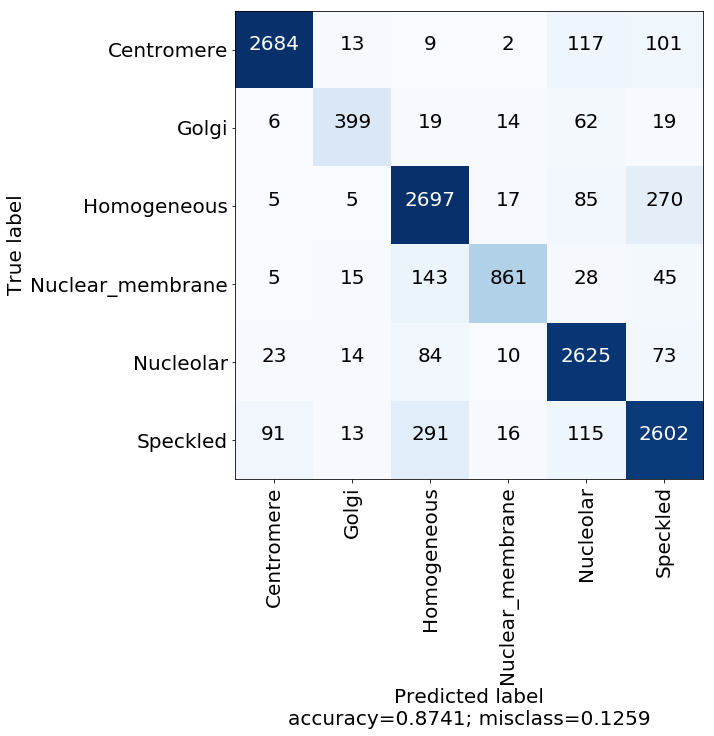

In [22]:
plt.rcParams["axes.grid"] = False
plt.rcParams.update({'font.size': 20})

labels = []

label = test_generator.class_indices
indexlabel = dict((value, key) for key, value in label.items())

for k,v in indexlabel.items():
    labels.append(v)

from sklearn.metrics import confusion_matrix
import itertools
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    accuracy = np.trace(cm) / float(np.sum(cm))
    misclass = 1 - accuracy
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion Matrix')

    print(cm)
#     fig = plt.figure()
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
#     plt.title(title)
#     plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=90)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label\naccuracy={:0.4f}; misclass={:0.4f}'.format(accuracy, misclass))
#     plt.savefig('plots/3.InceptionV3-2-Private-DataSet-CM.png', bbox_inches='tight', dpi = 100) 


plt.figure(figsize=(10,10))
plot_confusion_matrix(cm, classes=labels, title=' ')

In [23]:
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import confusion_matrix, classification_report
y_pred=predictions
y_pred_probabilities=y_pred

# y_pred = np.argmax(y_pred,axis = 1) 
y_actual = y_true

classnames=[]
for classname in test_generator.class_indices:
    classnames.append(classname)

confusion_mtx = confusion_matrix(y_actual, y_pred) 
print(confusion_mtx)
target_names = classnames
print(classification_report(y_actual, y_pred, target_names=target_names))

[[2684   13    9    2  117  101]
 [   6  399   19   14   62   19]
 [   5    5 2697   17   85  270]
 [   5   15  143  861   28   45]
 [  23   14   84   10 2625   73]
 [  91   13  291   16  115 2602]]
                  precision    recall  f1-score   support

      Centromere       0.95      0.92      0.94      2926
           Golgi       0.87      0.77      0.82       519
     Homogeneous       0.83      0.88      0.85      3079
Nuclear_membrane       0.94      0.78      0.85      1097
       Nucleolar       0.87      0.93      0.90      2829
        Speckled       0.84      0.83      0.83      3128

     avg / total       0.88      0.87      0.87     13578



In [24]:
total=sum(sum(cm))

sensitivity = cm[0,0]/(cm[0,0]+cm[1,0])
print('Sensitivity : ', sensitivity )

Specificity = cm[1,1]/(cm[1,1]+cm[0,1])
print('Specificity : ', Specificity )

Sensitivity :  0.9977695167286246
Specificity :  0.9684466019417476


In [25]:
y_pred_class = model.predict(test_data, verbose=1)

y_pred_class = [np.argmax(r) for r in y_pred_class]
test_y = [np.argmax(r) for r in test_labels]


from sklearn.metrics import confusion_matrix, precision_score, recall_score, f1_score, cohen_kappa_score, roc_auc_score, roc_curve

# Precision
print('Precision = ', precision_score(test_y, y_pred_class, average='weighted'))
# (None, 'micro', 'macro', 'weighted', 'samples')

# Recall
print('Recall = ', recall_score(test_y, y_pred_class, average='weighted'))

# f1_score
print('f1_score = ', f1_score(test_y, y_pred_class, average='weighted'))

13578/13578 [==============================] - 0s 24us/step
Precision =  0.8760901896121894
Recall =  0.8740609809986744
f1_score =  0.8739896611253581


In [26]:
from sklearn.metrics import roc_auc_score
from sklearn.preprocessing import LabelBinarizer

def multiclass_roc_auc_score(y_test, y_pred, average="weighted"):
    label_binarizer = LabelBinarizer()
    label_binarizer.fit(y_test)

    truth = label_binarizer.transform(y_test)
    pred = label_binarizer.transform(y_pred)
    return roc_auc_score(truth, pred, average=average)
# roc_auc_score
print('roc_auc_score = ', multiclass_roc_auc_score(test_y, y_pred_class))

roc_auc_score =  0.9199963104470373


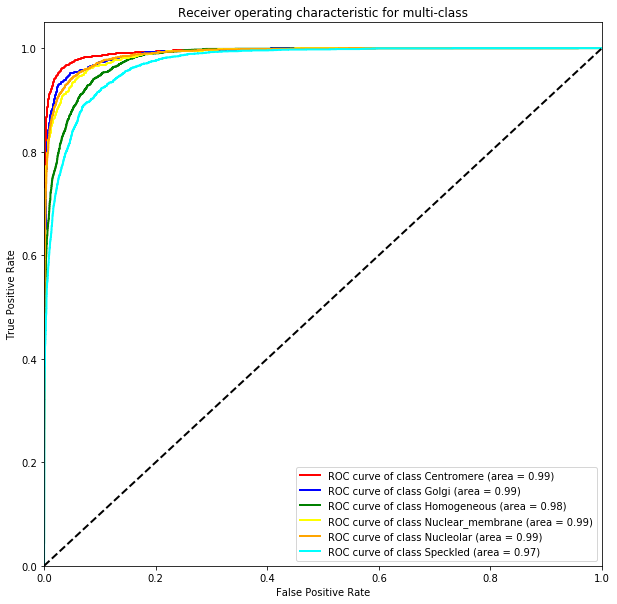

In [27]:
#ROC Curve for each class
from sklearn.metrics import roc_curve, auc
from sklearn.preprocessing import label_binarize
from sklearn.multiclass import OneVsRestClassifier
import matplotlib.pyplot as plt
%matplotlib inline  
from scipy import interp
from itertools import cycle

predict_class = np.argmax(preds, axis=1)

y_pred = preds
y_pred_probabilities=y_pred

y_pred = np.argmax(y_pred,axis = 1) 
y_actual = test_generator.classes

classnames=[]
for classname in test_generator.class_indices:
    classnames.append(classname)

y_actual_binary = label_binarize(y_actual, classes=[0, 1, 2, 3, 4, 5])
y_pred_binary = y_pred_probabilities
n_classes=6
lw=2

# Compute ROC curve and ROC area for each class
fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y_actual_binary[:, i], y_pred_binary[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Compute micro-average ROC curve and ROC area
fpr["micro"], tpr["micro"], _ = roc_curve(y_actual_binary.ravel(), y_pred_binary.ravel())
roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])

# Compute macro-average ROC curve and ROC area

# First aggregate all false positive rates
all_fpr = np.unique(np.concatenate([fpr[i] for i in range(n_classes)]))

# Then interpolate all ROC curves at this points
mean_tpr = np.zeros_like(all_fpr)
for i in range(n_classes):
    mean_tpr += interp(all_fpr, fpr[i], tpr[i])

# Finally average it and compute AUC
mean_tpr /= n_classes

fpr["macro"] = all_fpr
tpr["macro"] = mean_tpr
roc_auc["macro"] = auc(fpr["macro"], tpr["macro"])

# Plot all ROC curves
plt.figure(figsize=(10, 10))


colors = cycle(['red','blue','green','yellow','orange', 'aqua', 'cornflowerblue'])
for i, color in zip(range(n_classes), colors):
    plt.plot(fpr[i], tpr[i], color=color, lw=lw,
             label='ROC curve of class {0} (area = {1:0.2f})'
             ''.format(classnames[i], roc_auc[i]))

plt.plot([0, 1], [0, 1], 'k--', lw=lw)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic for multi-class')
plt.legend(loc="best")
plt.show()

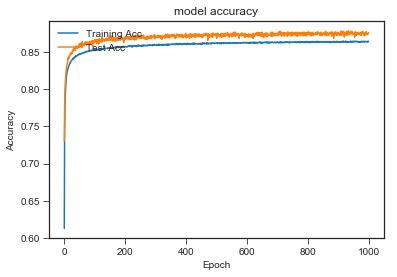

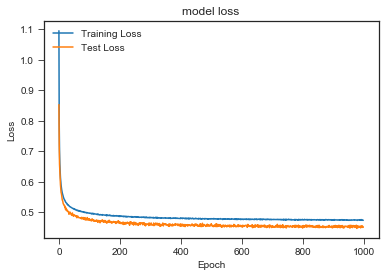

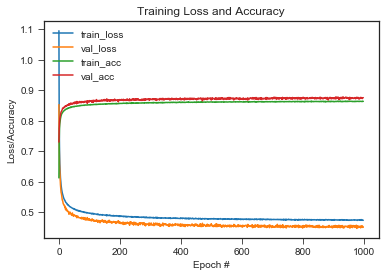

In [28]:
plt.style.use("seaborn-ticks")

plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.title('model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Training Acc', 'Test Acc'], loc='upper left')
plt.show()

# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Training Loss', 'Test Loss'], loc='upper left')
plt.show()

plt.figure()
N = epochs
plt.plot(np.arange(0, N), history.history["loss"], label="train_loss")
plt.plot(np.arange(0, N), history.history["val_loss"], label="val_loss")
plt.plot(np.arange(0, N), history.history["acc"], label="train_acc")
plt.plot(np.arange(0, N), history.history["val_acc"], label="val_acc")
plt.title("Training Loss and Accuracy")
plt.xlabel("Epoch #")
plt.ylabel("Loss/Accuracy")
plt.legend(loc="upper left")